https://hydrosource.ornl.gov/data/datasets/9505v3_1/

This dataset presents a suite of high-resolution downscaled hydro-climate projections over the conterminous United States (CONUS) based on multiple selected Global Climate Models (GCMs) from the Coupled Models Intercomparison Project phase 6 (CMIP6). The CMIP6 GCMs are downscaled using either statistical (DBCCA) or dynamical (RegCM) downscaling approaches based on two meteorological reference datasets (Daymet and Livneh). Subsequently, the downscaled precipitation, temperature, and wind speed are employed to drive two calibrated hydrologic models (VIC and PRMS), enabling the simulation of projected future hydrologic responses across the CONUS. Each ensemble member covers the 1980-2019 baseline and 2020-2059 near-future periods under the high-end (SSP585) emission scenario. Moreover, utilizing only DBCCA and Daymet, the projections are further extended to the 2060-2099 far-future period and across three additional emission scenarios (SSP370, SSP245, and SSP126). This dataset is formulated to support the SECURE Water Act Section 9505 Assessment for the US Department of Energy (DOE) Water Power Technologies Office (WPTO). For further details on this dataset, please refer to Kao et al. (2022) and Rastogi et al. (2022).

DATA & FILE OVERVIEW

1. File List:

        The majority of data are in daily temporal resolution, provided in a general format.:

                [Simulation Name]/[Variable Name]/[File Name]

        [Simulation Name]

                Simulations [DaymetV4] and [Livneh] are driven by historical Daymet and Livneh observations.

                Other simulation names are a combination of [GCM Name][SSP Scenarios][Ensemble ID][Downscaling Method][Reference Meteorological Observations].

        [GCM Name] This includes the following CMIP6 GCMs:

                ACCESS-CM2
                BCC-CSM2-MR
                CNRM-ESM2-1
                EC-Earth3
                MPI-ESM1-2-HR
                MRI-ESM2-0
                NorESM2-MM

        [SSP Scenarios] This includes the following emission scenarios:

                ssp585
                ssp370
                ssp245
                ssp126

        [Ensemble ID] This is the unique CMIP6 ensemble ID of each GCM simualtion

        [Downscaling Method] This includes the following downscaling methods:

                DBCCA
                RegCM

        [Reference Meteorological Observations] This includes the following reference meteorological observations:

                Daymet
                Livneh

        [Variable Name]  This includes the following variables:

                Field Name      Units   Description
                prcp            mm/day  precipitation
                tmax            deg C   daily maximum temperature
                tmin            deg C   daily minimum temperature
                wind            m/s     wind speed
                srad            W/m2    shortwave radiation (estimated by VIC-MetClim)
                lrad            W/m2    longwave radiation (estimated by VIC-MetClim)
                qair            kg/kg   specific humidity (estimated by VIC-MetClim)
                rhum            %       relative humidity (estimated by VIC-MetClim)
                vp              Pa      near surface vapor pressure (estimated by VIC-MetClim)
                vpd             Pa      near surface vapor pressure deficit (estimated by VIC-MetClim)
                pres            Pa      near surface atmospheric pressure (estimated by VIC-MetClim)
                runoff          mm/day  total runoff (baseflow + surface runoff) (estimated by VIC)
                runoffs         mm/day  surface runoff (estimated by VIC)
                runoffb         mm/day  baseflow (estimated by VIC)
                swe             mm      snow water equivalent (estimated by VIC)
                evap            mm/day  evapotranspiration (estimated by VIC)
                pet             mm/day  potential evaporation (estimated by VIC)
                soilm           mm      soil moisture (estimated by VIC)
                PRMS_runoff     mm/day  total runoff (baseflow + surface runoff) (estimated by PRMS)
                PRMS_runoffs    mm/day  surface runoff (estimated by PRMS)
                PRMS_runoffb    mm/day  baseflow (estimated by PRMS)
                PRMS_swe        mm      snow water equivalent (estimated by PRMS)
                PRMS_evap       mm/day  evapotranspiration (estimated by PRMS)
                PRMS_pet        mm/day  potential evaporation (estimated by PRMS)
                PRMS_soilm      mm      soil moisture (estimated by PRMS)

        [File Name]  This includes [Simulation Name], [Variable Name], and [Year] from 1950-2099. Files with a single year number contain data at daily resolution. Files with a range of years (e.g., 1980_2019) are temporally averaged/aggregated data, either at monthly or annual time scales.

        In addition to gridded data, spatially aggregated data are provided in the HUC_Summary and County_Summary folders. HUC_Summary provides summaries at 2-, 4-, 6-, and 8-digit US Hydrologic Unit Code watersheds (HUC02, HUC04, HUC06, HUC08). County_Summary provides summaries at both county and state levels, labeled by the FIPS code. Shapefiles used as the basis of this analysis are also included.


In [1]:
# Use Virtualizarr to construct a virtual dataset for 1 year
import xarray as xr
from virtualizarr import open_virtual_dataset
import fsspec
from concurrent.futures import ThreadPoolExecutor, wait
import pandas as pd
from pathlib import Path
from datetime import datetime as dt
import dask
import geopandas as gpd
from shapely import vectorized
import os
import glob

In [9]:
met_data = 'DaymetV4' #Or Livneh
hydro_model = 'VIC4' #Or ?
# variables = ['prcp', 'tmax', 'tmin', 'wind', 'rhum', 'srad', 'lrad']
variables = ['prcp']
start_year = '2023'
end_year = '2024'
simulation = 'CNRM-ESM2-1'
climate_scenario = 'ssp585'
reference_id = 'r1i1p1f2'
downscaling_method = 'DBCCA'

In [10]:
GLOBUS_ROOT = 'https://g-e320e6.63720f.75bc.data.globus.org/gen101/world-shared/doi-data/OLCF/202402/10.13139_OLCF_2311812'

def generate_file_names(met_data: str = 'DaymetV4', hydro_model:str = 'VIC4', variables:list = ['prcp', 'tmax', 'tmin', 'wind', 'rhum', 'srad', 'lrad'], start_year: str = '1980', end_year: str = '1985') -> list:
    files = []

    for variable in variables:
        for y in pd.date_range(start_year, end_year, freq='YS'):
            if y.year < 2019:
                file_path = f'{met_data}/{variable}/{met_data}_{hydro_model}_{variable}_{y.year}.nc'
            else:
                if met_data == 'DaymetV4':
                    met_data = 'Daymet'
                file_path = f'{simulation}_{climate_scenario}_{reference_id}_{downscaling_method}_{met_data}/{variable}/{simulation}_{climate_scenario}_{reference_id}_{downscaling_method}_{met_data}_{hydro_model}_{variable}_{y.year}.nc'
            url = f'{GLOBUS_ROOT}/{file_path}'
            files.append(url)
    return files
    
def pull_from_globus(url: str) -> str:
    local_path = fsspec.open_local(f"filecache::{url}", filecache={'cache_storage': '/tmp/fsspec_cache'}, same_names=True)
    return local_path

# Convert local paths to HTTPS URLs before saving
def local_to_url(local_path: str) -> str:
    
    filename = Path(local_path).name
    met_model, hydro_model, variable, year = filename.split('_')
    url = f'{GLOBUS_ROOT}/{met_model}/{variable}/{filename}'

    return url

In [11]:
files = generate_file_names(met_data, hydro_model, variables, start_year, end_year)
files 

['https://g-e320e6.63720f.75bc.data.globus.org/gen101/world-shared/doi-data/OLCF/202402/10.13139_OLCF_2311812/CNRM-ESM2-1_ssp585_r1i1p1f2_DBBCA_DaymetV4/prcp/CNRM-ESM2-1_ssp585_r1i1p1f2_DBBCA_DaymetV4_VIC4_prcp_2023.nc',
 'https://g-e320e6.63720f.75bc.data.globus.org/gen101/world-shared/doi-data/OLCF/202402/10.13139_OLCF_2311812/CNRM-ESM2-1_ssp585_r1i1p1f2_DBBCA_DaymetV4/prcp/CNRM-ESM2-1_ssp585_r1i1p1f2_DBBCA_DaymetV4_VIC4_prcp_2024.nc']

In [133]:
start_time = dt.now()
with ThreadPoolExecutor(max_workers=None) as executor:
    futures = [executor.submit(pull_from_globus, file) for file in files]
    wait(futures, timeout=60)

def downloaded_files(futures: list) -> list:
    downloaded_files = []
    for f in futures:
        try:
            downloaded_files.append(f.result())
        except:
            pass

    return downloaded_files

downloaded_files = downloaded_files(futures)
end_time = dt.now()

print('Time to download {} files: {} seconds'.format(len(downloaded_files), (end_time - start_time).seconds))

Time to download 2 files: 300 seconds


In [135]:
downloaded_files

['/tmp/fsspec_cache/DaymetV4_VIC4_prcp_2012.nc',
 '/tmp/fsspec_cache/DaymetV4_VIC4_prcp_2013.nc']

In [ ]:
import rioxarray as rxr
output_file = "/tmp/%s_%s_ORNL_data.zarr" % (start_year, end_year)
rasters = []
mask = gpd.read_file('../data/GIS/SkagitBoundary.json')
l = glob.iglob(os.path.join('/tmp/fsspec_cache/', '*.nc'))
for f in l:
   # open weather file and clip to watershed boundaries
    raster = rxr.open_rasterio(f, masked=True)
    raster = raster.rio.write_crs(mask.crs)
    raster = raster.rio.clip(mask.geometry)

    #add timestamp to list
    rasters.append(raster)
    
weather_dataset = xr.merge(rasters)
weather_dataset.to_zarr(output_file, mode='a')

In [67]:
z = xr.open_zarr("/tmp/2012_2015_ORNL_data.zarr")

<xarray.Dataset> Size: 316MB
Dimensions:      (time: 2192, y: 66, x: 78)
Coordinates:
    spatial_ref  int64 8B ...
  * time         (time) datetime64[ns] 18kB 1980-01-01T12:00:00 ... 1985-12-3...
  * x            (x) float64 624B -122.3 -122.3 -122.3 ... -120.8 -120.7 -120.7
  * y            (y) float64 528B 47.96 47.96 48.0 48.0 ... 49.25 49.29 49.29
Data variables:
    lrad         (time, y, x) float32 45MB dask.array<chunksize=(548, 17, 20), meta=np.ndarray>
    prcp         (time, y, x) float32 45MB dask.array<chunksize=(548, 17, 20), meta=np.ndarray>
    rhum         (time, y, x) float32 45MB dask.array<chunksize=(548, 17, 20), meta=np.ndarray>
    srad         (time, y, x) float32 45MB dask.array<chunksize=(548, 17, 20), meta=np.ndarray>
    tmax         (time, y, x) float32 45MB dask.array<chunksize=(548, 17, 20), meta=np.ndarray>
    tmin         (time, y, x) float32 45MB dask.array<chunksize=(548, 17, 20), meta=np.ndarray>
    wind         (time, y, x) float32 45MB dask.array<chunksize=(548, 17, 20), meta=np.ndarray>
Attributes: (12/22)
    Conventions:              CF-1.8
    Forcing:                  DaymetV4, aggregated to 4km ORNL CONUS-VIC4 grids
    NETCDF_DIM_EXTRA:         {time}
    NETCDF_DIM_time_DEF:      [365.0, 6.0]
    NETCDF_DIM_time_VALUES:   [1096.5, 1097.5, 1098.5, 1099.5, 1100.5, 1101.5...
    add_offset:               0.0
    ...                       ...
    lon#standard_name:        longitude
    lon#units:                degrees_east
    long_name:                incoming shortwave radiation
    scale_factor:             1.0
    title:                    SECURE Water Act 9505V3 Assessment
    units:                    ['W/m2', 'W/m2', 'W/m2', 'W/m2', 'W/m2', 'W/m2'...

In [73]:
z = z.rename({'x': 'lon', 'y': 'lat'})
z = z.drop_vars('spatial_ref')

In [99]:
z['time'] = z.time.dt.floor('D')

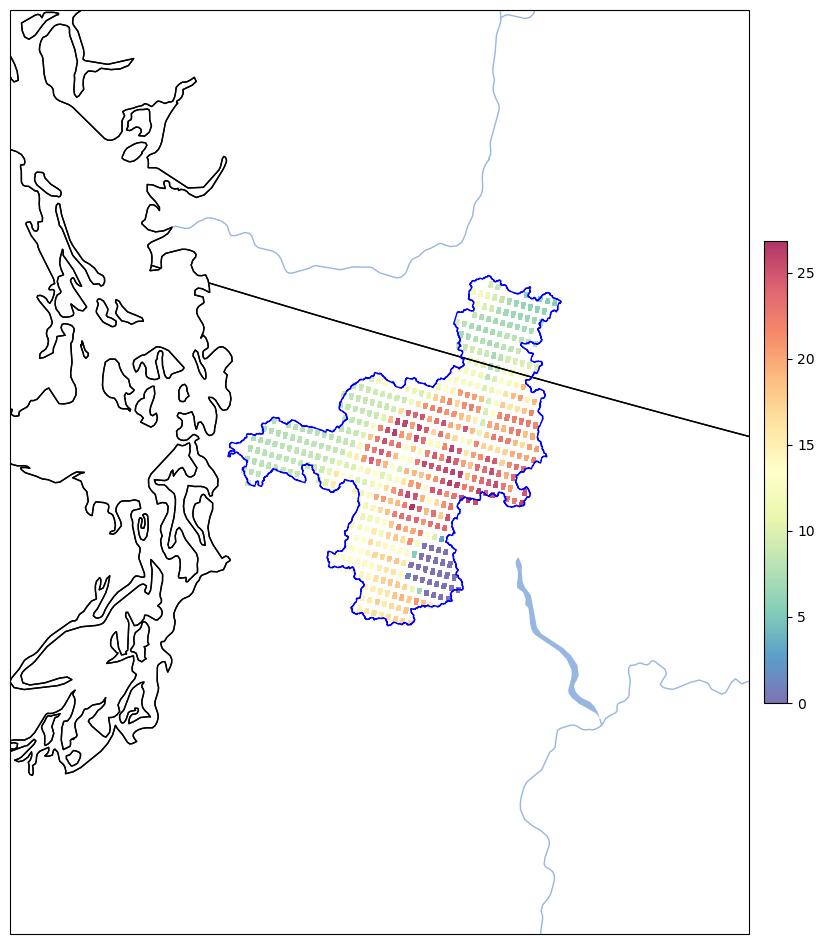

In [100]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

projection = ccrs.LambertConformal()
lons = z.lon
lats = z.lat
fig = plt.figure(figsize=[20, 12])
ax = plt.axes(projection=projection)
mesh = ax.pcolormesh(lons, lats, z.prcp.sel(time='1980-01-02'), transform=ccrs.PlateCarree(), cmap='Spectral_r', alpha=.8)
fig.colorbar(mesh, ax=ax, shrink=.5, pad=.01)
ax.add_feature(cfeature.COASTLINE.with_scale('10m'))
ax.add_feature(cfeature.STATES.with_scale('10m'))
ax.add_feature(cfeature.RIVERS.with_scale('10m'))
ax.add_feature(cfeature.LAKES.with_scale('10m'))
ax.set_extent([-120, -123, 47, 50], crs=ccrs.PlateCarree())
ax.add_geometries([mask.geometry[0]], ccrs.PlateCarree(), edgecolor='blue', facecolor='None')